# EEG Seizure Classification with Machine Learning
## Review for Data Preprocessing and Feature Extraction
### Data labeling
1. Set A in file Z - **Label - 0**: Contains EEG signals from healthy volunteers recorded with eyes closed. These serve as non-pathological baseline data representing normal brain activity.
2. Set D in file F - **Label - 1**: Includes EEG recordings from epileptic patients during seizure-free (inter-ictal) periods, specifically from the epileptogenic zone. These signals reflect the brain’s activity in between seizures and are critical for identifying pre-seizure patterns.
3. Set E in file S - **Label - 2**: Comprises EEG segments recorded during active seizure episodes (ictal periods). These provide direct examples of epileptic activity.

### Feature Extraction
#### Feature extraction from:
1. The original (raw) EEG signal
2. The Hilbert transformed envelopes of 4 wavelet sub-bands (cA5, cD5, cD4, cD3) after applying 5-level DWT
---
For each of the 4 DWT sub-bands, they compute the following 4 features:
1. Mean
2. Minimum
3. Maximum
4. Energy (sum of squares)
 - Entropy is not computed for wavelet bands
 - 4 x 4 = 16

From the raw EEG signal, they compute 5 features:
1. Mean
2. Minimum
3. Maximum
4. Energy
5. **Shannon Entropy**
 - Entropy captures the complexity and unpredictability of the EEG signal, which is important in seizure classification
 - 5

So after the feature extraction process, we will have 16 + 5 = 21 features

### Data loading

In [8]:
import pandas as pd
eeg_ml_df = pd.read_csv("data/processed/eeg_features.csv")

In [9]:
eeg_ml_df.shape

(300, 23)

In [10]:
eeg_ml_df.head()

,filename,label,cA5_mean,cA5_min,cA5_max,cA5_energy,cD5_mean,cD5_min,cD5_max,cD5_energy,...,cD4_energy,cD3_mean,cD3_min,cD3_max,cD3_energy,raw_mean,raw_min,raw_max,raw_energy,raw_entropy
0,Z001.txt,0,190.110926,34.851187,538.679565,6.106830e+06,128.289850,5.612702,440.196733,2.926945e+06,...,3.784481e+06,65.019843,1.543781,201.490143,2.815530e+06,6.816451,-190.0,185.0,7622197.0,3.820121
1,Z002.txt,0,190.632792,10.388940,585.876420,6.923143e+06,114.585174,7.176003,296.157452,2.357356e+06,...,5.417267e+06,91.602101,8.511173,354.007465,5.711797e+06,-52.444716,-254.0,169.0,21030412.0,3.842420
2,Z003.txt,0,209.066069,16.119211,540.513447,7.477365e+06,127.219183,10.156539,387.661732,2.933900e+06,...,3.638711e+06,78.883261,1.619288,259.064355,4.277687e+06,12.705150,-146.0,184.0,9767461.0,4.055136
3,Z004.txt,0,145.771983,8.376990,485.608607,3.889882e+06,108.177968,12.844111,423.515553,2.247831e+06,...,4.522186e+06,88.560551,0.766002,311.472311,5.325516e+06,-3.992433,-181.0,162.0,9143449.0,4.010141
4,Z005.txt,0,205.801250,8.593684,513.657617,7.482184e+06,91.651780,4.573690,296.076151,1.552644e+06,...,3.484284e+06,74.517711,4.250383,250.868084,3.928931e+06,-17.999268,-188.0,152.0,9590945.0,3.973299


# Unsupervised learning
## K-Means Clustering
- Use **Elbow method** to pick k.
- **Evaluate** using inertia, silhouette score, and confusion matrix against true labels (optional).
- Goal: See if EEG segments naturally fall into normal brain activity/seizure/non-seizure states without label supervision.

### Drop the Label and Standardize the Features

In [11]:
# Drop the label
X = eeg_ml_df.drop(columns=["filename", "label"])  # Only use the 21 numeric features

In [12]:
# Standardize features to have zero mean and unit variance
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(eeg_ml_df.drop(columns=["filename", "label"]))

### Determine Optimal Number of Clusters (k) Using Elbow Method

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

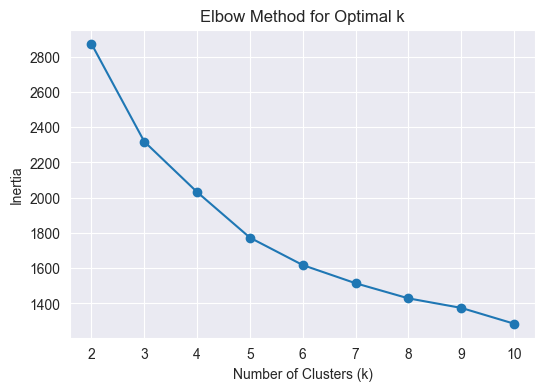

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

> #### Optimal clustering k = 3 based on the Elbow method, which also matches the known class structure (healthy, interictal, ictal).

### Fit KMeans with the Chosen k
- The resulting cluster labels are saved to the DataFrame for further analysis and to explore whether unsupervised clusters align with seizure states


In [17]:
best_k = 3  # Based on elbow method
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Save cluster assignment to DataFrame
eeg_ml_df["kmeans_cluster"] = cluster_labels

### Inspect Cluster Sizes
- How many data points fall into each cluster.
- It's a sanity check to detect imbalance or skewed clustering that could distort evaluation.
- k=3: The result observed that Cluster 0 dominates (222 samples), with Clusters 1 and 2 being much smaller.

In [29]:
# Check how many samples are assigned to each cluster
eeg_ml_df["kmeans_cluster"].value_counts().sort_index()

0    222
1     27
2     51
Name: kmeans_cluster, dtype: int64

### Cluster-wise Feature Importance
- Compute the mean value of each feature within each cluster.
- Visualize the mean values of all EEG features per cluster, then scale the features to z-scores for interpretability.
- Clusters differ significantly in features like cA5_energy, cD5_energy, and raw_energy. For instance, Cluster 2 shows very high raw energy, potentially aligning with ictal (seizure) activity. This supports biological interpretation of clusters.
> The comparison between unsupervised and supervised learning in this analysis reveals complementary insights about EEG feature relevance. In the unsupervised K-Means clustering, feature contributions were indirectly interpreted through cluster-wise averages and z-scored heatmaps, highlighting signals like cA5_energy, cD5_energy, and raw_energy as key differentiators across natural groupings. These clusters partially aligned with seizure states, suggesting that some features naturally structure the data even without label supervision.
> In contrast, the supervised Random Forest model explicitly leveraged seizure labels during training and returned direct feature importances, clearly ranking cD3_energy, cD4_energy, and cD3_max as most predictive of seizure states. Interestingly, features like cD3_energy and cA5_energy emerged as important in both analyses, underscoring their potential physiological significance.

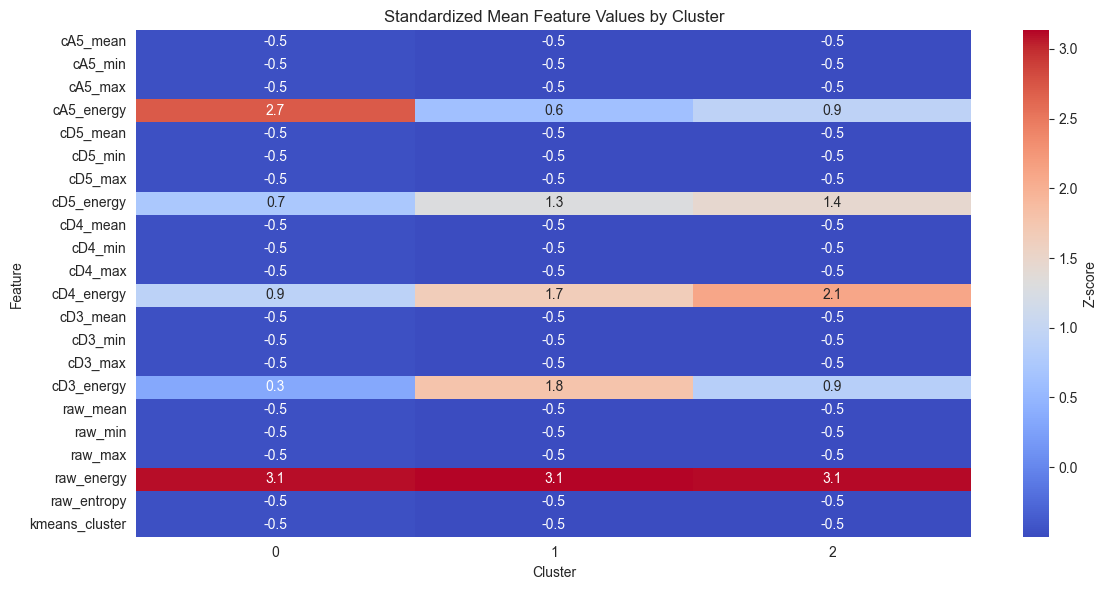

In [20]:
import seaborn as sns

# Select only numeric columns
numeric_cols = eeg_ml_df.drop(columns=["filename", "label"]).columns

# Compute mean per feature per cluster
cluster_means = eeg_ml_df.groupby("kmeans_cluster")[numeric_cols].mean()

# Normalize each column to z-scores across clusters for better visual contrast
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means.T),  # transpose to scale features
    index=cluster_means.columns,
    columns=cluster_means.index.astype(str)
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_scaled, cmap="coolwarm", annot=True, fmt=".1f", cbar_kws={"label": "Z-score"})
plt.title("Standardized Mean Feature Values by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Visualize Clusters in 2D Space Using PCA
- PCA reduces the feature space to two dimensions, allowing visualization of clusters on a 2D plot. This is a qualitative evaluation of clustering structure.
- The PCA plot shows that clusters are somewhat separable but with overlap, suggesting that while some seizure states form distinct patterns, others might be harder to distinguish using only the extracted features.

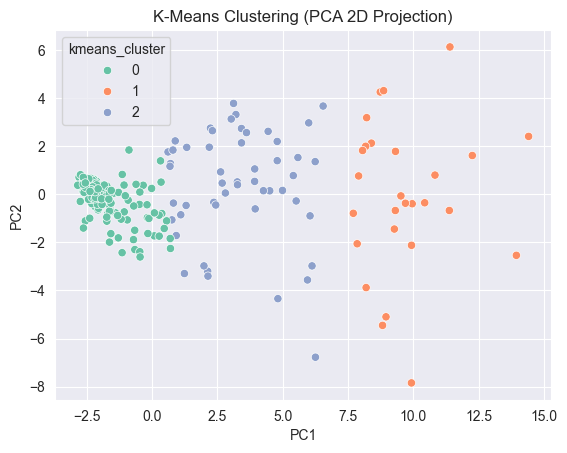

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = eeg_ml_df.copy()
pca_df["PC1"] = X_pca[:, 0]
pca_df["PC2"] = X_pca[:, 1]

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="kmeans_cluster", palette="Set2")
plt.title("K-Means Clustering (PCA 2D Projection)")
plt.show()

### Visualize in 3D Using t-SNE
- Use t-SNE to plot clusters in 3 dimensions.
- t-SNE offers nonlinear dimensionality reduction that preserves local structure. A 3D scatter plot helps visualize potential substructure that PCA might miss.

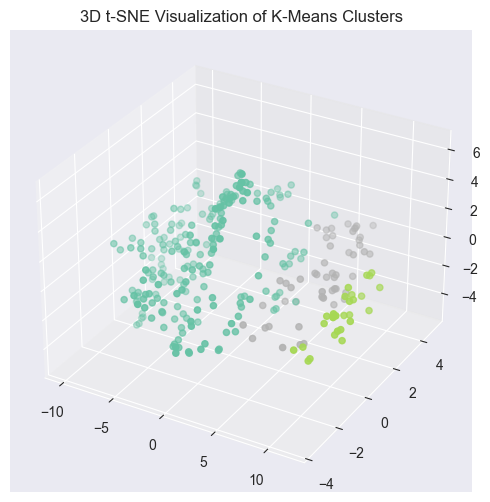

In [22]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

X_3d = TSNE(n_components=3, random_state=42).fit_transform(X_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=cluster_labels, cmap='Set2')
ax.set_title("3D t-SNE Visualization of K-Means Clusters")
plt.show()

### Evaluate Cluster Agreement with True Labels
- ARI quantitatively compares these unsupervised clusters with true seizure labels. A higher ARI means clusters align well with actual seizure states.
- An ARI of 0.221 suggests moderate alignment. THESE clusters reflect some real label structure, but not perfectly. This is expected in EEG data where states may not be linearly separable.

In [23]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(eeg_ml_df["label"], eeg_ml_df["kmeans_cluster"])
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.221


### Compare Predicted vs. True Class Proportions (Cluster-Label Mapping)
- For each cluster, look at the distribution of true labels.
- Helps assess whether clusters align cleanly with seizure states.
- This evaluates how seizure labels are distributed within each cluster. It's another way to assess cluster "purity" or class composition.
- Cluster 0 mostly includes label 0 (healthy), Cluster 2 is dominated by label 2 (ictal), and Cluster 1 is ambiguous. This supports that this KMeans clustering only partially discovers seizure-related patterns without label supervision.

In [25]:
pd.crosstab(index=eeg_ml_df["kmeans_cluster"], columns=eeg_ml_df["label"], normalize='index')

label,0,1,2
kmeans_cluster,,,
0,0.45045,0.432432,0.117117
1,0.00000,0.000000,1.000000
2,0.00000,0.078431,0.921569


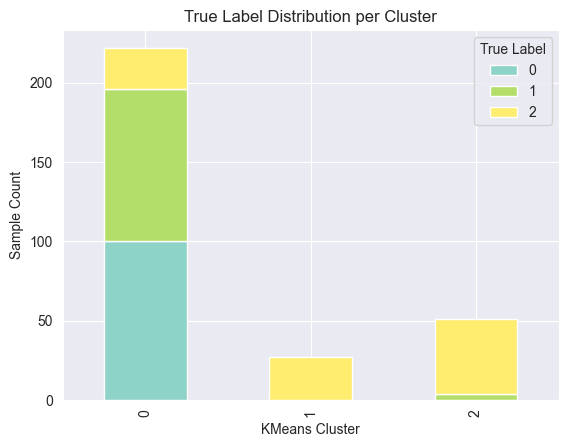

In [27]:
pd.crosstab(index=eeg_ml_df["kmeans_cluster"], columns=eeg_ml_df["label"]).plot(
    kind="bar", stacked=True, colormap="Set3"
)
plt.title("True Label Distribution per Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("Sample Count")
plt.legend(title="True Label")
plt.show()

## Interpret Model Outputs
### The EEG data has meaningful latent structure
1. The unsupervised K-Means model identified 3 distinct clusters, which corresponded partially—but not perfectly—to the true seizure state labels (ictal, preictal, interictal).
- Cluster 0 dominated by non-seizure (label 0),
- Cluster 1 and 2 showed higher proportions of seizure-related segments (label 2),
This implies that without supervision, the model can still uncover natural structure in EEG features that aligns with brain states.
### Cluster-wise feature patterns match physiological expectations
2. The heatmap of cluster-wise z-scored feature means revealed that clusters linked to seizures (especially Cluster 2) had:
- Higher energy values (cA5_energy, cD5_energy, raw_energy)
- Elevated values in lower-frequency wavelet bands
### PCA and t-SNE projections show partial separability
3. 2D PCA captured general group structure but with some overlap.
4. 3D t-SNE offered better separation, especially revealing that seizure-related segments tend to cluster more tightly.
This suggests that non-linear embeddings like t-SNE are more suitable for visualizing EEG clusters than linear projections alone.
### Cluster sizes are highly imbalanced
5. Cluster 0 has ~74% of the data, while Cluster 1 is only ~9%. This may indicate that seizure states are underrepresented and that clustering naturally separates out dominant resting/non-seizure states.
### Random Forest confirms and refines feature importance
6. Supervised learning (Random Forest) revealed the top predictive features: cD3_energy, cD4_energy, raw_energy, and cD3_max stood out as the most important. These features overlap with those highlighted in clustering (e.g., cD3_energy), strengthening confidence in their utility for seizure detection.
### Comparison between unsupervised and supervised learning
7. Unsupervised clustering is useful for uncovering hidden structure in EEG data and aligns partially with seizure states.
8. Supervised learning confirms and quantifies feature relevance more explicitly.